In [1]:
import numpy as np
import scipy.stats as st
from scipy.optimize import root_scalar
import pandas as pd
import matplotlib.pyplot as plt
import math

Implementação dos modelos teóricos de fluidização para encontrar valores esperados nos experimentos e nas simulações

Declarando vazão a ser estudada:

In [2]:
vaz_l_min = np.arange(35, 85, 5)
vazoes = np.array(vaz_l_min, dtype = str)
vazoes = np.char.add(vazoes,["lpm"])
vaz = vaz_l_min*1/60000
print("As vazões de trabalho escolhidas foram: " + str (vaz_l_min) + " L/min")

As vazões de trabalho escolhidas foram: [35 40 45 50 55 60 65 70 75 80] L/min


Declarando valores de entrada (Unidades no S.I.):

In [3]:
pi = math.pi
#Equipamento:
Db = 0.10
Rb = Db/2
Ab = pi*Rb**2
Hb = 1
h0 = 0.06
dh = 0.06
n_tomadas = 14
hmax = 0.06*(n_tomadas-1)

#Fluido:
rhol = 998.2
mu   = 0.001002
u    = vaz/Ab

#Partícula:
rhop = 1822
dp   = 0.00595
rp   = dp/2
Vp   = 4/3*pi*rp**3
Ap   = 4*pi*rp**2
n_p   = 8000
Vnp  = n_p*Vp
Mnp  = rhop*Vnp

#Geral
g   = 9.81
Ar  = dp**3*rhol*(rhop - rhol)*g/mu**2
Re0 = Ar**(1/3)*((18/(Ar**(2/3)))**0.824 + (0.322/(Ar**(1/3)))**0.412)**(-1.214) #Turton and Clarck (1987)
u0  = Re0*mu/(dp*rhol)

Encontrando a velocidade terminal:

In [4]:
Ar, Re0, u0

(1692481.0495412615, 2170.7625507455205, 0.3662229114670291)

Criando array de P(h)

In [5]:
P_h = pd.DataFrame(np.arange(h0,hmax,dh), columns = ["Tomada"])

Encontrando n de R-Z:

In [6]:
def minimized (n):
    return (4.8-n) - 0.043*Ar**0.57*(n-2.4)

n = root_scalar(minimized, x0 = 0, x1 = 2.5)
n

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 2.415618835558612

In [7]:
n = n.root

Encontrando k de R-Z:

In [8]:
def k1(dp, Db):
    return 1 - 1.15*(dp/Db)**0.6
def k2(Re0):
    return 1.09 - 0.11*math.log(Re0)
def k3(Re0):
    return (7/Re0)+0.8

if Re0 < 35:
    k = k1(dp, Db)
elif 35 <= Re0 < 100:
    k = min(k1(dp,Db), k3(Re0))
elif 100 <= Re0 < 1000:
    k = min(k1(dp,Db), k2(Re0))
else:
    k = k1(dp, Db)
k

0.788452440356302

Encontrando eps para cada vazão por R-Z:

In [9]:
eps = pd.DataFrame((u/(u0*k))**(1/n), index = vazoes).transpose()

Encontrando altura de expansão do leito a partir dos valores encontrados de eps por R-Z

In [10]:
H_rz = Vnp/(Ab*(1 - eps))
H_rz

,35lpm,40lpm,45lpm,50lpm,55lpm,60lpm,65lpm,70lpm,75lpm,80lpm
0,0.261271,0.28256,0.305704,0.33111,0.359265,0.390766,0.426365,0.467036,0.514058,0.569166


Text(0.5, 0, 'Velocidade da corrente livre [m/s]')

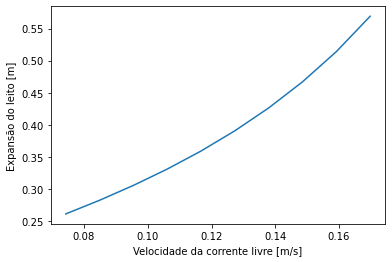

In [11]:
plt.plot(u, H_rz.iloc[0,:])
plt.ylabel("Expansão do leito [m]")
plt.xlabel("Velocidade da corrente livre [m/s]")

Encontrando valores para dp/dz a partir da porosidade:

In [12]:
dP_dz = (1 - eps)*(rhop - rhol)*g

In [13]:
dP_dz

,35lpm,40lpm,45lpm,50lpm,55lpm,60lpm,65lpm,70lpm,75lpm,80lpm
0,3474.951248,3213.140543,2969.883232,2742.000459,2527.115739,2323.398854,2129.405817,1943.974308,1766.152788,1595.150942


Definindo função para calcular pressão em cada ponto a pratir de R-Z:

In [14]:
def Press(i):
    return pd.DataFrame(P_h.iloc[i].Tomada * dP_dz.iloc[0,:]).transpose()

Calculando pressão em cada ponto a partir de R-Z:

In [15]:
#Criando um DataFrame vazio
P = pd.DataFrame()

#Acrescentando ao DataFrame os valores encontrados para a pressão
for i in range(P_h.size):
    P = P.append(Press(i))

#Criando um nome (valor numérico crescente) para os índices de P
P.index = np.arange(0,P_h.size)

#Acrescentando as distâncias das tomadas de pressão no DataFrame
P = P_h.join(P)

#Calculando os valores a partir dos quais a pressão não deve mudar e substituindo no DataFrame original
for i in range(P.Tomada.size): #Para todas as linhas
    for j in range(P.shape[1]-1): #para todas as colunas
        if P.Tomada.iloc[i] > H_rz.iloc[0,j]: #Se o valor da altura da tomada de pressão for maior do que a expansão do leito
            P.iloc[i,j+1] = Vnp/Ab*(rhop - rhol)*g #Substitua P pela queda de pressão total do leito
            #P.iloc[i,j+1] = P.iloc[i-1,j+1]   #Substitua seu valor pelo valor anterior.

In [16]:
P

,Tomada,35lpm,40lpm,45lpm,50lpm,55lpm,60lpm,65lpm,70lpm,75lpm,80lpm
0,0.06,208.497075,192.788433,178.192994,164.520028,151.626944,139.403931,127.764349,116.638458,105.969167,95.709057
1,0.12,416.994150,385.576865,356.385988,329.040055,303.253889,278.807862,255.528698,233.276917,211.938335,191.418113
2,0.18,625.491225,578.365298,534.578982,493.560083,454.880833,418.211794,383.293047,349.915375,317.907502,287.127170
3,0.24,833.988300,771.153730,712.771976,658.080110,606.507777,557.615725,511.057396,466.553834,423.876669,382.836226
4,0.30,907.905026,907.905026,890.964970,822.600138,758.134722,697.019656,638.821745,583.192292,529.845837,478.545283
5,0.36,907.905026,907.905026,907.905026,907.905026,907.905026,836.423587,766.586094,699.830751,635.815004,574.254339
6,0.42,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,894.350443,816.469209,741.784171,669.963396
7,0.48,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,847.753338,765.672452
8,0.54,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,861.381509
9,0.60,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026,907.905026


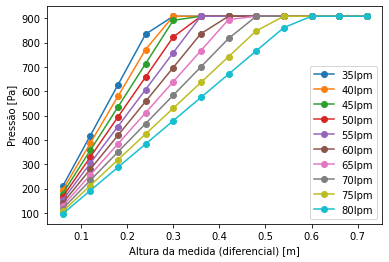

In [17]:
plt.plot(P.Tomada,P.iloc[:,1:], '-o')
"""plt.plot(P.Tomada,P.iloc[:,1], '0.0')
plt.plot(P.Tomada,P.iloc[:,2], '0.15')
plt.plot(P.Tomada,P.iloc[:,3], '0.3')
plt.plot(P.Tomada,P.iloc[:,4], '0.45')
plt.plot(P.Tomada,P.iloc[:,5], '0.60')
plt.plot(P.Tomada,P.iloc[:,6], '0.75')
plt.plot(P.Tomada,P.iloc[:,7], '0.9')"""
plt.ylabel("Pressão [Pa]")
plt.xlabel("Altura da medida (diferencial) [m]")
plt.legend(vazoes)